# SIT225 Week 7 — Data Analysis & Interpretation (Linear Regression)

In [ ]:
# Config
CSV_PATH = "sensor_data.csv"     # Change filename if different
USE_PLOTLY = False

# Filtering settings
LOWER_TEMP_QUANTILE = 0.05
UPPER_TEMP_QUANTILE = 0.95

RANDOM_SEED = 42

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import zscore

if USE_PLOTLY:
    import plotly.express as px
    import plotly.graph_objects as go

pd.set_option("display.precision", 3)

## Load data

In [3]:
# Load CSV
df = pd.read_csv(CSV_PATH)

# Try to normalize column names if needed
cols = {c.lower().strip(): c for c in df.columns}
def get_col(possible, fallback=None):
    for p in possible:
        if p in cols:
            return cols[p]
    return fallback

col_ts = get_col(["timestamp", "time", "datetime"])
col_t  = get_col(["temperature_c", "temp_c", "temperature", "temp"])
col_h  = get_col(["humidity_pct", "humidity", "rh"])

if col_t is None or col_h is None:
    raise ValueError("Could not find temperature and humidity columns. "
                     "Expected columns like 'temperature_C'/'temperature' and 'humidity_pct'/'humidity'.")

# Clean types
if col_ts and df[col_ts].dtype == object:
    try:
        df[col_ts] = pd.to_datetime(df[col_ts], errors="coerce")
    except Exception:
        pass

df[col_t] = pd.to_numeric(df[col_t], errors="coerce")
df[col_h] = pd.to_numeric(df[col_h], errors="coerce")

# Drop NAs
df = df.dropna(subset=[col_t, col_h]).reset_index(drop=True)

print("Rows:", len(df))
display(df.head())

Rows: 6993


,timestamp,temperature_C,humidity_pct
0,2025-08-15 15:50:01,16.9,60.2
1,2025-08-15 15:50:03,16.9,60.2
2,2025-08-15 15:50:05,16.9,60.2
3,2025-08-15 15:50:07,16.9,60.2
4,2025-08-15 15:50:09,16.9,60.3


## Basic stats

In [4]:
print(df[[col_t, col_h]].describe())

       temperature_C  humidity_pct
count       6993.000      6993.000
mean          14.834        67.091
std            0.596         1.383
min           13.900        60.200
25%           14.400        66.800
50%           14.600        67.300
75%           15.200        67.800
max           16.900        70.000


## Linear Regression on all data

In [5]:
X = df[[col_t]].values  # independent variable (temperature)
y = df[col_h].values    # dependent variable (humidity)

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, )

print(f"Linear model: humidity = {lr.coef_[0]:.4f} * temperature + {lr.intercept_:.4f}")
print(f"R^2={r2:.4f}, RMSE={rmse:.3f}")

# Interpolate 100 equally spaced temperature values
t_min, t_max = float(np.min(X)), float(np.max(X))
t_test = np.linspace(t_min, t_max, 100).reshape(-1, 1)
h_test = lr.predict(t_test)

Linear model: humidity = -1.5164 * temperature + 89.5859
R^2=0.4266, RMSE=1.097


In [6]:
X = df[[col_t]].values  # independent variable (temperature)
y = df[col_h].values    # dependent variable (humidity)

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, )

print(f"Linear model: humidity = {lr.coef_[0]:.4f} * temperature + {lr.intercept_:.4f}")
print(f"R^2={r2:.4f}, RMSE={rmse:.3f}")

# Interpolate 100 equally spaced temperature values
t_min, t_max = float(np.min(X)), float(np.max(X))
t_test = np.linspace(t_min, t_max, 100).reshape(-1, 1)
h_test = lr.predict(t_test)

Linear model: humidity = -1.5164 * temperature + 89.5859
R^2=0.4266, RMSE=1.097


In [7]:
X = df[[col_t]].values  # independent variable (temperature)
y = df[col_h].values    # dependent variable (humidity)

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, )

print(f"Linear model: humidity = {lr.coef_[0]:.4f} * temperature + {lr.intercept_:.4f}")
print(f"R^2={r2:.4f}, RMSE={rmse:.3f}")

# Interpolate 100 equally spaced temperature values
t_min, t_max = float(np.min(X)), float(np.max(X))
t_test = np.linspace(t_min, t_max, 100).reshape(-1, 1)
h_test = lr.predict(t_test)

Linear model: humidity = -1.5164 * temperature + 89.5859
R^2=0.4266, RMSE=1.097


### Plot data + trend line

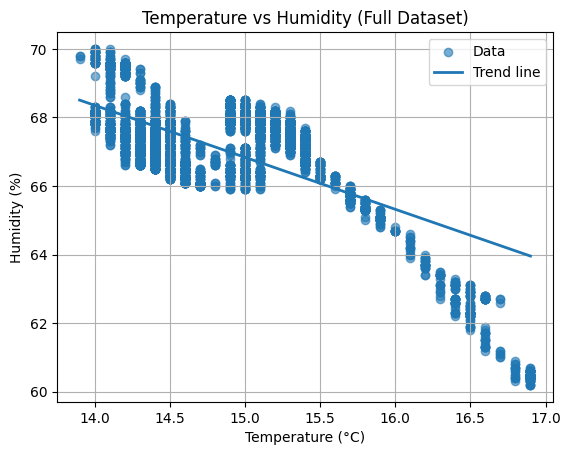

In [8]:
# Matplotlib version
plt.figure()
plt.scatter(X, y, alpha=0.6, label="Data")
plt.plot(t_test, h_test, linewidth=2, label="Trend line")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Temperature vs Humidity (Full Dataset)")
plt.legend()
plt.grid(True)
plt.show()

if USE_PLOTLY:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X.squeeze(), y=y, mode="markers", name="Data"))
    fig.add_trace(go.Scatter(x=t_test.squeeze(), y=h_test, mode="lines", name="Trend line"))
    fig.update_layout(xaxis_title="Temperature (°C)", yaxis_title="Humidity (%)",
                      title="Temperature vs Humidity (Full Dataset)")
    fig.show()

## Identify outliers


Detected 193 outliers with |z| > 2.


,temperature_C,humidity_pct,residual,resid_z
0,16.9,60.2,-3.758,-3.588
1,16.9,60.2,-3.758,-3.588
2,16.9,60.2,-3.758,-3.588
3,16.9,60.2,-3.758,-3.588
4,16.9,60.3,-3.658,-3.493


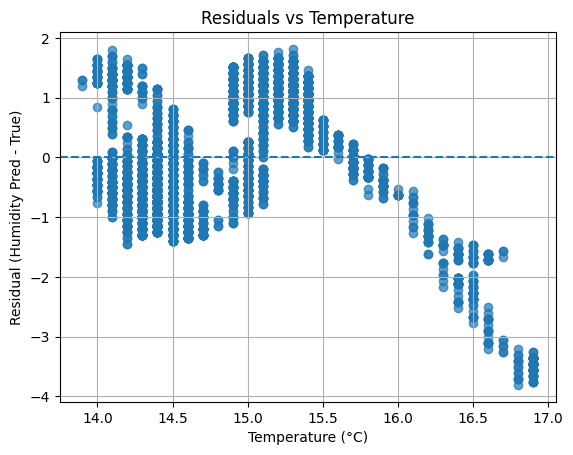

In [9]:
residuals = y - y_pred
z = zscore(residuals, nan_policy="omit")
df["residual"] = residuals
df["resid_z"] = z
outlier_mask = np.abs(z) > 2

print(f"Detected {outlier_mask.sum()} outliers with |z| > 2.")
display(df[outlier_mask][[col_t, col_h, "residual", "resid_z"]].head())

# Visualize residuals
plt.figure()
plt.scatter(X.squeeze(), residuals, alpha=0.7, label="Residuals")
plt.axhline(0, linestyle="--")
plt.xlabel("Temperature (°C)")
plt.ylabel("Residual (Humidity Pred - True)")
plt.title("Residuals vs Temperature")
plt.grid(True)
plt.show()

## Filter by temperature quantiles

In [10]:
low_cut = df[col_t].quantile(LOWER_TEMP_QUANTILE)
high_cut = df[col_t].quantile(UPPER_TEMP_QUANTILE)

df_q = df[(df[col_t] >= low_cut) & (df[col_t] <= high_cut)].copy()

X2 = df_q[[col_t]].values
y2 = df_q[col_h].values

lr2 = LinearRegression().fit(X2, y2)
y2_pred = lr2.predict(X2)
r2_2 = r2_score(y2, y2_pred)
rmse_2 = mean_squared_error(y2, y2_pred, )

t2_min, t2_max = float(np.min(X2)), float(np.max(X2))
t2_test = np.linspace(t2_min, t2_max, 100).reshape(-1, 1)
h2_test = lr2.predict(t2_test)

print(f"[Filtered by temp quantiles {LOWER_TEMP_QUANTILE:.2f}-{UPPER_TEMP_QUANTILE:.2f}]")
print(f"Linear model: humidity = {lr2.coef_[0]:.4f} * temperature + {lr2.intercept_:.4f}")
print(f"R^2={r2_2:.4f}, RMSE={rmse_2:.3f}")

[Filtered by temp quantiles 0.05-0.95]
Linear model: humidity = -0.2372 * temperature + 70.7956
R^2=0.0219, RMSE=0.489


### Compare full vs filtered

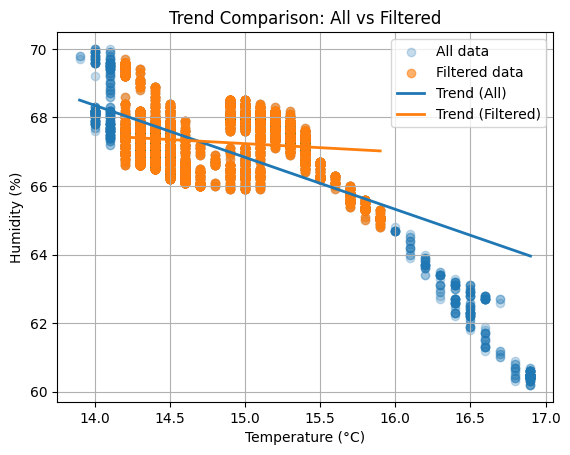

In [11]:
plt.figure()
plt.scatter(X, y, alpha=0.25, label="All data")
plt.scatter(X2, y2, alpha=0.6, label="Filtered data")
plt.plot(t_test, h_test, linewidth=2, label="Trend (All)")
plt.plot(t2_test, h2_test, linewidth=2, label="Trend (Filtered)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Trend Comparison: All vs Filtered")
plt.legend()
plt.grid(True)
plt.show()

## Remove statistical outliers

In [12]:
df_no_outliers = df[~outlier_mask].copy()

X3 = df_no_outliers[[col_t]].values
y3 = df_no_outliers[col_h].values

lr3 = LinearRegression().fit(X3, y3)
y3_pred = lr3.predict(X3)
r2_3 = r2_score(y3, y3_pred)
rmse_3 = mean_squared_error(y3, y3_pred, )

t3_min, t3_max = float(np.min(X3)), float(np.max(X3))
t3_test = np.linspace(t3_min, t3_max, 100).reshape(-1, 1)
h3_test = lr3.predict(t3_test)

print(f"[Removed residual outliers |z|>2]")
print(f"Linear model: humidity = {lr3.coef_[0]:.4f} * temperature + {lr3.intercept_:.4f}")
print(f"R^2={r2_3:.4f}, RMSE={rmse_3:.3f}")

[Removed residual outliers |z|>2]
Linear model: humidity = -0.8455 * temperature + 79.7565
R^2=0.2034, RMSE=0.725


### Plot comparison: All vs Quantile-Filtered vs Outlier-Removed

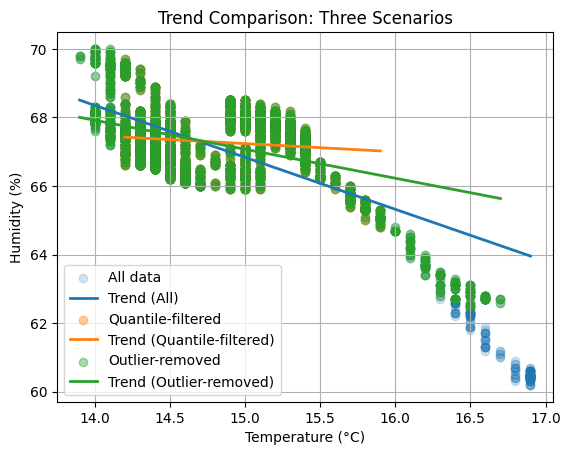


Summary of slopes (humidity per °C):
All data:            -1.5164
Quantile-filtered:   -0.2372
Outlier-removed:     -0.8455


In [13]:
plt.figure()
plt.scatter(X, y, alpha=0.2, label="All data")
plt.plot(t_test, h_test, linewidth=2, label="Trend (All)")

plt.scatter(X2, y2, alpha=0.4, label="Quantile-filtered")
plt.plot(t2_test, h2_test, linewidth=2, label="Trend (Quantile-filtered)")

plt.scatter(X3, y3, alpha=0.4, label="Outlier-removed")
plt.plot(t3_test, h3_test, linewidth=2, label="Trend (Outlier-removed)")

plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Trend Comparison: Three Scenarios")
plt.legend()
plt.grid(True)
plt.show()

print("\nSummary of slopes (humidity per °C):")
print(f"All data:            {lr.coef_[0]:.4f}")
print(f"Quantile-filtered:   {lr2.coef_[0]:.4f}")
print(f"Outlier-removed:     {lr3.coef_[0]:.4f}")